# Image Generation via Generative Adversarial Networks

## import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_12_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))
real            = data['real_images']

In [3]:
print('size of real data:', real.shape)

size of real data: (4324, 32, 32)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 3
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)
   
    for r in range(nRow): 
        for c in range(nCol):
            k = c * 300 + r * nCol * 300
            axes[r, c].imshow(image[k], cmap='gray')

    plt.tight_layout()
    plt.show()

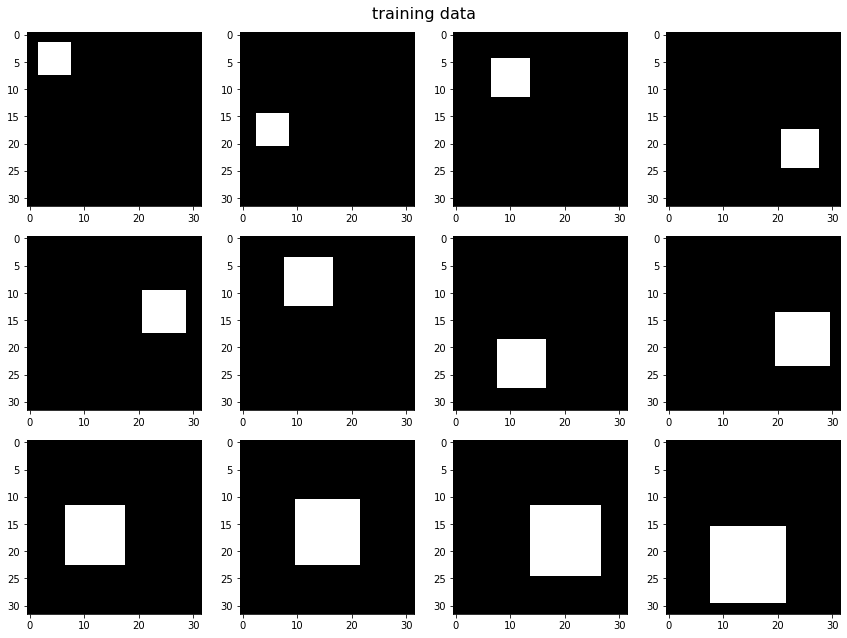

In [5]:
plot_image('training data', real)

## custom data loader for the PyTorch framework

In [6]:
class dataset(Dataset):
    
    def __init__(self, image):
        
        self.image = image
    
    def __getitem__(self, index):
        
        sample  = self.image[index]
        sample  = torch.FloatTensor(sample).unsqueeze(dim=0)

        return (sample)
    
    def __len__(self):

        number_image = len(self.image)

        return (number_image)

## setting device

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [8]:
print(device)

cuda


In [9]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## construct datasets and dataloaders 

In [10]:
size_minibatch  = 32
dim_latent      = 64 # input latent vector fixed dimension 

dataset_real    = dataset(real)
dataloader_real = torch.utils.data.DataLoader(dataset_real, batch_size=size_minibatch, shuffle=True, drop_last=True)

## neural networks 

In [11]:
class Discriminator(nn.Module): 
    
    def __init__(self):
        
        super(Discriminator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
            nn.LeakyReLU(0.2),
        )
        
        self.fc = nn.Sequential(
            nn.Linear(128, 64),
            nn.LeakyReLU(0.2),
            nn.Linear(64, 32),
            nn.LeakyReLU(0.2),
            nn.Linear(32, 16),
            nn.LeakyReLU(0.2),
            nn.Linear(16, 8),
            nn.LeakyReLU(0.2),
            nn.Linear(8, 1)
        )
        
    def forward(self, x):
        out = self.conv(x)
        out = nn.Flatten()(out)
        out = self.fc(out)
        
        return out


In [12]:
class Generator(nn.Module):
    
    def __init__(self):
        
        super(Generator, self).__init__()
        
        self.conv = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=dim_latent, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(8),
            nn.LeakyReLU(0.2),
            
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            nn.Conv2d(in_channels=8, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            
            nn.Sigmoid()
        )
    
    def forward(self, x):

        out = self.conv(x)
        
        return out

## build network

In [13]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("BatchNorm") != -1:
        nn.init.constant_(m.weight, 1.)
        nn.init.constant_(m.bias, 1.)
    elif classname.find("Linear") != -1:
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 1.)

In [14]:
generator       = Generator().to(device)
discriminator   = Discriminator().to(device)

generator = generator.apply(weights_init)
discriminator = discriminator.apply(weights_init)

optimizer_generator = torch.optim.Adam(generator.parameters(), lr=0.0011, betas=(0.5, 0.999))
optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=0.0011, betas=(0.5, 0.999))

## compute the prediction

In [15]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the accuracy

In [16]:
def compute_bounding_mask(prediction_binary):
    
    bounding_mask = torch.zeros_like(prediction_binary)
    
    for i in range(prediction_binary.shape[0]):
        prediction = prediction_binary[i]
        (idx_row, idx_col) = torch.nonzero(prediction, as_tuple=True)
        
        if len(idx_row) > 0: 
            idx_row_min = idx_row.min()
            idx_row_max = idx_row.max()
        
            idx_col_min = idx_col.min()
            idx_col_max = idx_col.max()
    
            bounding_mask[i, idx_row_min:idx_row_max+1, idx_col_min:idx_col_max+1] = 1 
    
    return bounding_mask

In [17]:
def compute_accuracy(prediction):

    binary      = (prediction >= 0.5)
    mask        = compute_bounding_mask(binary)
    
    intersection = (binary & mask).float().sum((1, 2))
    union        = (binary | mask).float().sum((1, 2))

    eps         = 1e-8
    correct     = (intersection + eps) / (union + eps)
    accuracy    = correct.mean() * 100.0
    accuracy    = accuracy.cpu() 
    
    return accuracy

## train

In [18]:
# def train(generator, discriminator, dataloader):
    
#     loss_generator_epoch = []
#     loss_discriminator_epoch = []
    
#     for index_batch, (real) in enumerate(dataloader):
#         real        = real.to(device)
#         size_batch  = len(real)
#         latent      = torch.randn(size_batch, dim_latent, device=device)
#         latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

#         # ---------------------------------------------------------------------------
#         #  
#         # update the generator
#         #  
#         # ---------------------------------------------------------------------------
#         generator.train()
#         discriminator.eval()
        
#         optimizer_generator.zero_grad()
#         fake = compute_prediction(generator, latent)
#         prediction_fake = compute_prediction(discriminator, fake)

#         loss_generator = -torch.mean(prediction_fake)
#         loss_generator.backward()
#         optimizer_generator.step()

#         # ---------------------------------------------------------------------------
#         #  
#         # update the discriminator
#         #  
#         # ---------------------------------------------------------------------------
#         generator.eval()
#         discriminator.train()
        
#         optimizer_discriminator.zero_grad()
        
#         prediction_real = compute_prediction(discriminator, real)
#         loss_real = -torch.mean(prediction_real)
        
#         fake = compute_prediction(generator, latent)
#         prediction_fake = compute_prediction(discriminator, fake.detach())
#         loss_fake = torch.mean(prediction_fake)
        
#         alpha = torch.randn((real.size(0), 1, 1, 1), device=device)
#         interpolates = (alpha * real + ((1 - alpha) * fake)).requires_grad_(True)
#         discriminator_interpolates = compute_prediction(discriminator, interpolates)
#         grad_outputs = torch.ones(discriminator_interpolates.size(), device=device, requires_grad=False)
#         gradients = torch.autograd.grad(
#             outputs = discriminator_interpolates,
#             inputs = interpolates,
#             grad_outputs = grad_outputs,
#             create_graph = True,
#             retain_graph = True,
#             only_inputs = True
#         )[0]
#         gradients = gradients.view(gradients.size(0), -1)
#         gradient_penalty = torch.mean((gradients.norm(2, dim=1) -1) ** 2)

#         loss_discriminator = loss_real + loss_fake + 10 * gradient_penalty
#         loss_discriminator.backward()
#         optimizer_discriminator.step()
        
#         loss_generator_epoch.append(loss_generator.item())
#         loss_discriminator_epoch.append(loss_discriminator.item())
    
#     return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)


def train(generator, discriminator, dataloader):
    
    loss_generator_epoch = []
    loss_discriminator_epoch = []
    
    for index_batch, (real) in enumerate(dataloader):
        real        = real.to(device)
        size_batch  = len(real)
        latent      = torch.randn(size_batch, dim_latent, device=device)
        latent      = torch.reshape(latent, [size_batch, dim_latent, 1, 1])

        # ---------------------------------------------------------------------------
        #  
        # update the generator
        #  
        # ---------------------------------------------------------------------------
        generator.train()
        discriminator.eval()
        
        optimizer_generator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_fake = compute_prediction(discriminator, fake)
        label_fake = torch.ones_like(prediction_fake)
        loss_label = nn.BCEWithLogitsLoss()(prediction_fake, label_fake)
        loss_generator = loss_label
        loss_generator.backward()
        optimizer_generator.step()

        # ---------------------------------------------------------------------------
        #  
        # update the discriminator
        #  
        # ---------------------------------------------------------------------------
        generator.eval()
        discriminator.train()
        
        optimizer_discriminator.zero_grad()
        fake = compute_prediction(generator, latent)
        prediction_real = compute_prediction(discriminator, real)
        prediction_fake = compute_prediction(discriminator, fake)
        loss_real = nn.BCEWithLogitsLoss()(prediction_real, torch.ones_like(prediction_real, device=device))
        loss_fake = nn.BCEWithLogitsLoss()(prediction_fake, torch.zeros_like(prediction_fake, device=device))
        loss_discriminator = (loss_real + loss_fake) / 2.
        loss_discriminator.backward()
        optimizer_discriminator.step()
        
        loss_generator_epoch.append(loss_generator.item())
        loss_discriminator_epoch.append(loss_discriminator.item())
    
    return np.mean(loss_generator_epoch), np.mean(loss_discriminator_epoch)

## test

In [19]:
def test(generator, latent):
    
    generator.eval()
    
    prediction  = generator(latent)
    prediction  = prediction.squeeze(axis=1)
    accuracy    = compute_accuracy(prediction)
    
    return accuracy

## training epoch

In [20]:
number_epoch    = 500
accuracy_epoch  = np.zeros(number_epoch)
loss_generator = np.zeros(number_epoch)
loss_discriminator = np.zeros(number_epoch)

num_latent_test = 100
latent_test = torch.randn(num_latent_test, dim_latent, device=device)
latent_test = torch.reshape(latent_test, [num_latent_test, dim_latent, 1, 1])

for i in range(number_epoch):
    loss_generator_epoch, loss_discriminator_epoch = train(generator, discriminator, dataloader_real)
    accuracy = test(generator, latent_test)
    accuracy_epoch[i] = accuracy
    
    loss_generator[i] = loss_generator_epoch
    loss_discriminator[i] = loss_discriminator_epoch
    print(f'epoch {i}, loss_generator = {loss_generator_epoch}, loss_discriminator={loss_discriminator_epoch}, accuracy={accuracy}')

epoch 0, loss_generator = 0.7830118815104167, loss_discriminator=0.7010087543063693, accuracy=85.39830780029297
epoch 1, loss_generator = 0.7675823167242386, loss_discriminator=0.7030457474567272, accuracy=82.90269470214844
epoch 2, loss_generator = 0.8758105505395819, loss_discriminator=0.6385555141501956, accuracy=81.8272705078125
epoch 3, loss_generator = 0.9985896419595789, loss_discriminator=0.6048567204563706, accuracy=80.04447937011719
epoch 4, loss_generator = 1.1059355289847763, loss_discriminator=0.583775747484631, accuracy=79.77926635742188
epoch 5, loss_generator = 0.9635988994880959, loss_discriminator=0.6233917479161863, accuracy=80.331298828125
epoch 6, loss_generator = 0.9024248213679702, loss_discriminator=0.6313283092445797, accuracy=79.93148803710938
epoch 7, loss_generator = 0.9251472808696606, loss_discriminator=0.6178684930006663, accuracy=79.88243865966797
epoch 8, loss_generator = 0.9281626017005356, loss_discriminator=0.6236695271951181, accuracy=79.06584167480

epoch 73, loss_generator = 4.005058206452263, loss_discriminator=0.2762829983675921, accuracy=91.21717834472656
epoch 74, loss_generator = 3.717232682969835, loss_discriminator=0.3242301362532157, accuracy=89.72064971923828
epoch 75, loss_generator = 3.612649650706185, loss_discriminator=0.3563372995014544, accuracy=92.54811096191406
epoch 76, loss_generator = 3.9108242436691567, loss_discriminator=0.30737810714377295, accuracy=92.69203186035156
epoch 77, loss_generator = 4.0770993634506505, loss_discriminator=0.3043306292207153, accuracy=91.58243560791016
epoch 78, loss_generator = 4.0187237876432915, loss_discriminator=0.3326357045659312, accuracy=92.25660705566406
epoch 79, loss_generator = 4.093690143249653, loss_discriminator=0.34856491927747374, accuracy=93.20059204101562
epoch 80, loss_generator = 3.775698737744932, loss_discriminator=0.3486027950489963, accuracy=93.79265594482422
epoch 81, loss_generator = 4.332031806310018, loss_discriminator=0.30921758203594774, accuracy=93.3

epoch 146, loss_generator = 5.9451680483641445, loss_discriminator=0.19763633338389575, accuracy=93.99901580810547
epoch 147, loss_generator = 5.91983642578125, loss_discriminator=0.16886602998883635, accuracy=92.2822265625
epoch 148, loss_generator = 5.275719130480731, loss_discriminator=0.186285795878481, accuracy=93.51472473144531
epoch 149, loss_generator = 5.608909387941714, loss_discriminator=0.17317214036981265, accuracy=91.46451568603516
epoch 150, loss_generator = 5.731089816270051, loss_discriminator=0.15387877874352313, accuracy=93.3097915649414
epoch 151, loss_generator = 6.1813570163868095, loss_discriminator=0.13445109299349564, accuracy=93.24607849121094
epoch 152, loss_generator = 6.2107965292754, loss_discriminator=0.13824011279201065, accuracy=79.26958465576172
epoch 153, loss_generator = 6.325542919724076, loss_discriminator=0.13083853539493348, accuracy=93.23147583007812
epoch 154, loss_generator = 7.3475077240555375, loss_discriminator=0.10508296885700137, accuracy

epoch 219, loss_generator = 6.149990989543774, loss_discriminator=0.1845245574635488, accuracy=88.94285583496094
epoch 220, loss_generator = 5.945349906992029, loss_discriminator=0.18249984775428418, accuracy=91.88652038574219
epoch 221, loss_generator = 6.255417456450286, loss_discriminator=0.17492274669585406, accuracy=91.45623779296875
epoch 222, loss_generator = 7.181421852111816, loss_discriminator=0.145783343800792, accuracy=91.31886291503906
epoch 223, loss_generator = 6.643771314620972, loss_discriminator=0.13766744125772407, accuracy=82.34669494628906
epoch 224, loss_generator = 7.630583582984077, loss_discriminator=0.14281993080620412, accuracy=87.76361083984375
epoch 225, loss_generator = 6.730831488856563, loss_discriminator=0.15365114610780167, accuracy=92.25772094726562
epoch 226, loss_generator = 6.905494160122341, loss_discriminator=0.14861624621682698, accuracy=92.60713195800781
epoch 227, loss_generator = 6.8154614466208, loss_discriminator=0.13955017090947539, accura

epoch 292, loss_generator = 6.569004101223416, loss_discriminator=0.08092231255852514, accuracy=93.68537902832031
epoch 293, loss_generator = 5.970119146064476, loss_discriminator=0.09410089900096258, accuracy=95.17188262939453
epoch 294, loss_generator = 6.086759962858977, loss_discriminator=0.08615126375246931, accuracy=91.5030746459961
epoch 295, loss_generator = 6.387437232335409, loss_discriminator=0.09630629908017538, accuracy=94.33460998535156
epoch 296, loss_generator = 6.401308149761624, loss_discriminator=0.09010546778639157, accuracy=89.21217346191406
epoch 297, loss_generator = 5.887254193977073, loss_discriminator=0.10619859160786425, accuracy=90.56757354736328
epoch 298, loss_generator = 6.153802749845717, loss_discriminator=0.10565848251183828, accuracy=95.09236907958984
epoch 299, loss_generator = 6.486135096020169, loss_discriminator=0.09882200533455168, accuracy=89.9478988647461
epoch 300, loss_generator = 6.366056198543973, loss_discriminator=0.10704058422534554, acc

epoch 365, loss_generator = 7.963600639060692, loss_discriminator=0.15119367606110043, accuracy=93.90022277832031
epoch 366, loss_generator = 7.675801639203672, loss_discriminator=0.1665182853186572, accuracy=92.57530212402344
epoch 367, loss_generator = 7.723172957808883, loss_discriminator=0.16686879026669044, accuracy=95.18753814697266
epoch 368, loss_generator = 8.449515378033674, loss_discriminator=0.14718371958092408, accuracy=94.62101745605469
epoch 369, loss_generator = 8.546486702671757, loss_discriminator=0.13607652173550042, accuracy=92.51377868652344
epoch 370, loss_generator = 6.387501065819352, loss_discriminator=0.18556063539452022, accuracy=95.54945373535156
epoch 371, loss_generator = 7.781277833161531, loss_discriminator=0.1390655122421406, accuracy=90.30764770507812
epoch 372, loss_generator = 8.154698278285839, loss_discriminator=0.13843336764861036, accuracy=93.21041870117188
epoch 373, loss_generator = 8.084221144075746, loss_discriminator=0.14335262739547977, acc

epoch 438, loss_generator = 8.921746751997206, loss_discriminator=0.1071218536959754, accuracy=89.45752716064453
epoch 439, loss_generator = 9.558159089971472, loss_discriminator=0.0984190139643572, accuracy=94.74906921386719
epoch 440, loss_generator = 8.646566154338695, loss_discriminator=0.09621778802463302, accuracy=93.96100616455078
epoch 441, loss_generator = 8.098430047211824, loss_discriminator=0.10599082242007608, accuracy=90.98944091796875
epoch 442, loss_generator = 9.346959640361645, loss_discriminator=0.10513751212231538, accuracy=94.21095275878906
epoch 443, loss_generator = 8.474998573020653, loss_discriminator=0.11067898414201206, accuracy=91.85950469970703
epoch 444, loss_generator = 8.652270963456896, loss_discriminator=0.10292276746282975, accuracy=87.70401763916016
epoch 445, loss_generator = 8.64774364542078, loss_discriminator=0.10379554703831673, accuracy=89.11283874511719
epoch 446, loss_generator = 8.522558470125551, loss_discriminator=0.10549916431859688, accu

---

# functions for presenting the results

---

In [21]:
def function_result_01():

    num_latent_visualize = 16

    latent_visualize = torch.randn(num_latent_visualize, dim_latent, device=device)
    latent_visualize = torch.reshape(latent_visualize, [num_latent_visualize, dim_latent, 1, 1]) 

    prediction = compute_prediction(generator, latent_visualize)
    prediction = prediction.squeeze(axis=1)
    prediction_binary = (prediction >= 0.5)
    bounding_mask = compute_bounding_mask(prediction_binary)
        
    fake = prediction.detach().cpu()
    mask = bounding_mask.detach().cpu()

    nRow = 4
    nCol = 4 
    size = 3 
    
    title = 'fake image'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(fake[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)

    plt.tight_layout()
    plt.show()
    
    title = 'bounding mask'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow): 
        for c in range(nCol):
            k = c + r * nCol
            axes[r, c].imshow(mask[k], cmap='gray', vmin=0, vmax=1)
            axes[r, c].xaxis.set_visible(False)
            axes[r, c].yaxis.set_visible(False)
                        
    plt.tight_layout()
    plt.show()

In [22]:
def function_result_02():

    title           = 'accuracy'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'accuracy'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)
    
    plt.plot(accuracy_epoch)
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_03():

    print('final accuracy = %9.8f' % (accuracy_epoch[-1]))

---

## results

---


################################################################################
#
# RESULT # 01
#
################################################################################



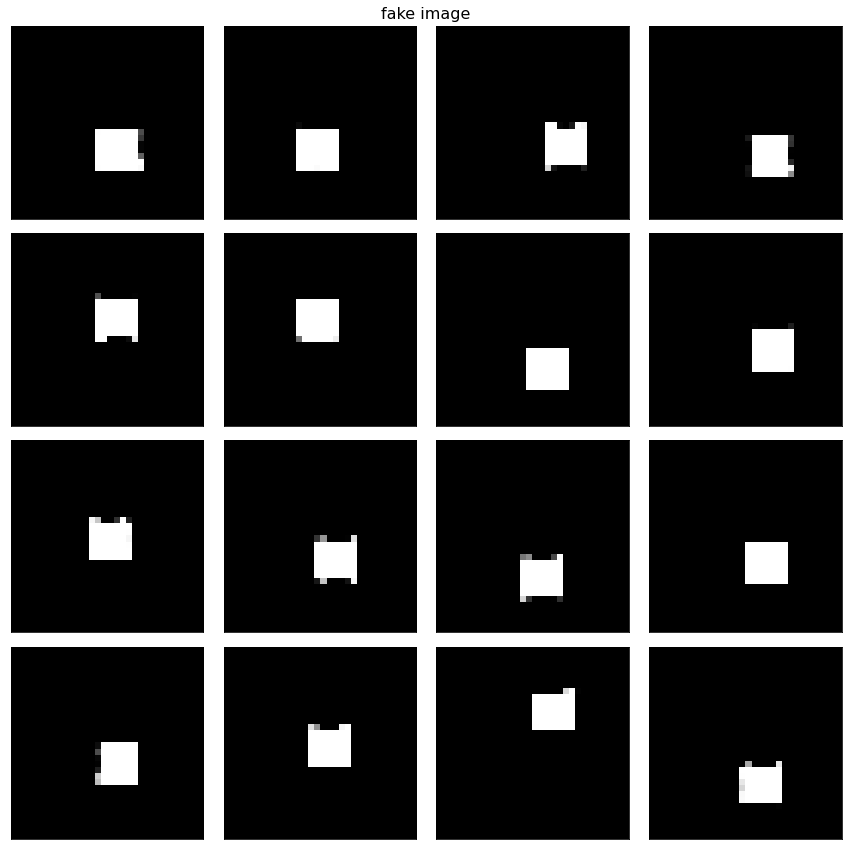

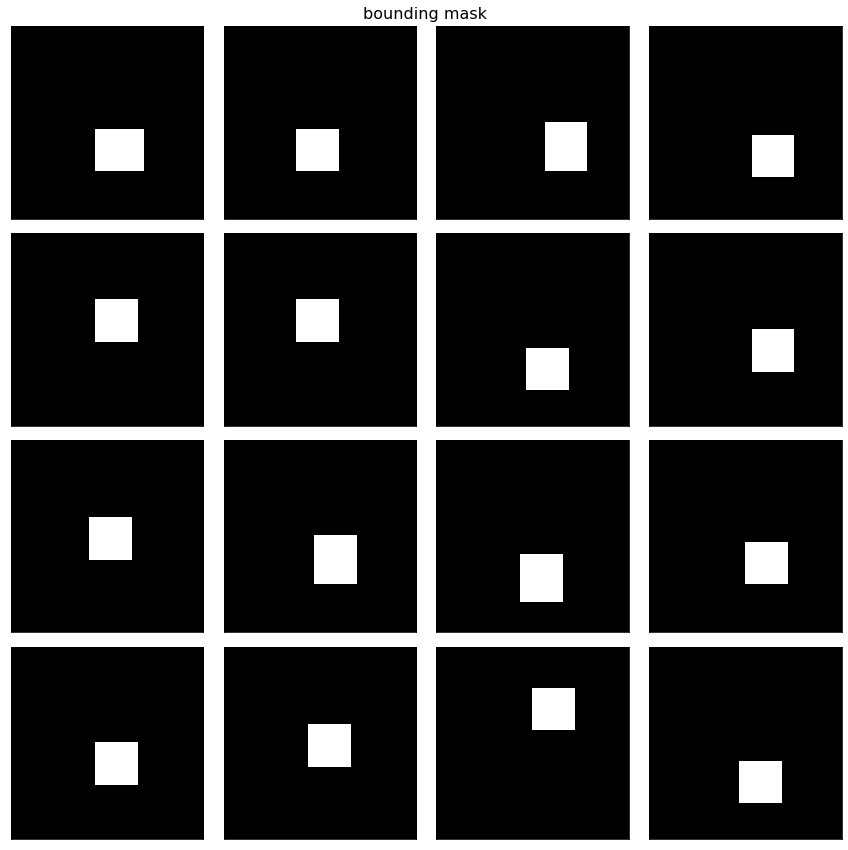


################################################################################
#
# RESULT # 02
#
################################################################################



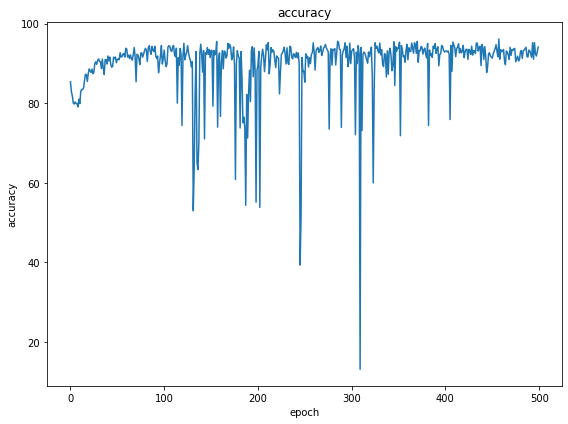


################################################################################
#
# RESULT # 03
#
################################################################################

final accuracy = 94.09832001


In [24]:
number_result = 3

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1) 
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)